In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools
from tools import mutant_colorset
from tools import condition_colorset

In [213]:
cov_thresh = 1e6
# fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_plusflat_resample1000000.csv')
# fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_wTechnicalandResamples_ByTimepoint.csv')
fitness_data = p.read_csv('../data/fitnesses_merged_NoWeight_wTechnical_ByTimepoint.csv')
# fitness_data = p.read_csv('../data/fitnesses_merged_default_technical_timepoint.csv')

In [297]:
df_merged_predictions = p.read_csv('../../StarryNight/fitness_prediction_40x_pergen_moreneutrals_BATCH_master_100steps_stepsize2_2xmax_D1to6.csv',index_col=0)

df_merged_predictions = df_merged_predictions[df_merged_predictions['dimension']==0]

barcodes = np.unique(df_merged_predictions['barcode'].values)
conditions = np.unique(df_merged_predictions['condition'].values)

fitnesses = {}

for condition in conditions:
    fitnesses[condition] = []
    for bc in barcodes:
        fitnesses[condition].append(df_merged_predictions[(df_merged_predictions['barcode']==bc) & (df_merged_predictions['condition']==condition)]['fitness'].values[0])

In [300]:
old_data = p.DataFrame()
old_data['barcode'] = barcodes
for condition in conditions:
    old_data[f'{condition}_fitness'] = fitnesses[condition]
merged_fitness_data = p.merge(fitness_data,old_data,on='barcode')

In [301]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

In [302]:
conditions

array(['1.4Glucose', '1.6Glucose', '1.7Glucose', '1.8Glucose',
       '2.5Glucose', '24_Hour_Transfer_PC', '500_M3_Batch_20',
       '500_M3_Batch_21', '500_M3_Batch_23_FT_99', 'Benomyl_2ug/mL',
       'DMSO', 'Ferm_40_Hour_Transfer', 'Ferm_44_Hour_Transfer',
       'Ferm_50_Hour_Transfer', 'Ferm_54_Hour_Transfer',
       'Fluconazole_2ug/mL', 'Geldanamycin8.5uM', 'M3_Batch_13',
       'M3_Batch_18', 'M3_Batch_19_allpool', 'M3_Batch_3',
       'M3_Batch_6_PC', 'Radicicol_5uM', 'Resp_5_Day_Transfer',
       'Resp_7_Day_Transfer'], dtype=object)

In [303]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
#                   '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

old_nonm3_conditions = {''}

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }

old_nonm3_conditions = ['1.4Glucose', '1.6Glucose', '1.7Glucose', '1.8Glucose',
       '2.5Glucose', '24_Hour_Transfer_PC', 'Benomyl_2ug/mL',
       'DMSO', 'Ferm_40_Hour_Transfer', 'Ferm_44_Hour_Transfer',
       'Ferm_50_Hour_Transfer', 'Ferm_54_Hour_Transfer',
       'Fluconazole_2ug/mL', 'Geldanamycin8.5uM','Radicicol_5uM', 'Resp_5_Day_Transfer',
       'Resp_7_Day_Transfer']


# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]



In [304]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

In [277]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

fitness_cols = [col for col in this_data.columns if '_fitness' in col]

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]


In [278]:
bigbatch_conditions.keys()

dict_keys(['1BB_M3', '1BB_Baffle', '1BB_1.4%Gluc', '1BB_1.8%Gluc', '1BB_1%Raf', '1BB_0.5%Raf', '1BB_1%Gly'])

In [306]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

train_cols = [col + '_fitness' for col in m3_conditions]
test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions]

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

# train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
# test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]



In [307]:
np.repeat(train_means,10).reshape(len(train_means),10)

array([[0.39451588, 0.39451588, 0.39451588, ..., 0.39451588, 0.39451588,
        0.39451588],
       [1.12667838, 1.12667838, 1.12667838, ..., 1.12667838, 1.12667838,
        1.12667838],
       [0.30735382, 0.30735382, 0.30735382, ..., 0.30735382, 0.30735382,
        0.30735382],
       ...,
       [0.01393791, 0.01393791, 0.01393791, ..., 0.01393791, 0.01393791,
        0.01393791],
       [0.35614052, 0.35614052, 0.35614052, ..., 0.35614052, 0.35614052,
        0.35614052],
       [0.02686217, 0.02686217, 0.02686217, ..., 0.02686217, 0.02686217,
        0.02686217]])

In [281]:
train_means = np.nanmean(this_data[train_cols].values,axis=1)
repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
train_stds = np.nanstd(this_data[train_cols].values,axis=1)
repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
test_z_scores = (this_data[test_cols].values-repeated_means)/repeated_stds

In [312]:
test_cols

['1BB_Baffle_fitness',
 '1BB_1.4%Gluc_fitness',
 '1BB_1.8%Gluc_fitness',
 '1BB_1%Raf_fitness',
 '1BB_0.5%Raf_fitness',
 '1BB_1%Gly_fitness',
 '1.4Glucose_fitness',
 '1.6Glucose_fitness',
 '1.7Glucose_fitness',
 '1.8Glucose_fitness',
 '2.5Glucose_fitness',
 '24_Hour_Transfer_PC_fitness',
 'Benomyl_2ug/mL_fitness',
 'DMSO_fitness',
 'Ferm_40_Hour_Transfer_fitness',
 'Ferm_44_Hour_Transfer_fitness',
 'Ferm_50_Hour_Transfer_fitness',
 'Ferm_54_Hour_Transfer_fitness',
 'Fluconazole_2ug/mL_fitness',
 'Geldanamycin8.5uM_fitness',
 'Radicicol_5uM_fitness',
 'Resp_5_Day_Transfer_fitness',
 'Resp_7_Day_Transfer_fitness']

In [308]:
condition_uncertainties = {}

train_conditions = m3_conditions

for condition in train_conditions:
    all_cols = []
    for rep in conditions[condition.split('_fitness')[0]]:
        for t in range(5):
            repT = f'{rep}_T{t}to{t+1}_fitness'
            if  repT in fitness_data.columns:
                all_cols.append(repT)
                
    condition_uncertainties[condition] = (np.nanmean(fitness_data[all_cols],axis=1),np.nanstd(fitness_data[all_cols],axis=1))
                

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [309]:
condition_uncertainties

{'13': (array([ 2.88636383e-01,  1.54348259e+00,  1.45543249e-01,  1.13426785e+00,
          1.03761554e+00,  1.27246473e+00,  1.10800293e+00,  2.02440335e-01,
          1.26484218e+00,  1.87395187e-01,  1.26407796e+00,  1.23038557e+00,
          1.40704779e+00,  1.27938314e+00,  1.75383995e-01,  1.01218525e+00,
          3.99448047e-02, -8.22471152e-02,  8.32124559e-01,  2.83132640e-01,
          6.85799983e-01,  9.66021696e-01,  8.52488040e-01,  5.18644152e-01,
          1.04684608e+00,  1.58363789e-01,  2.89624009e-01,  1.36974464e+00,
          2.63971246e-01,  8.93245225e-01,  2.39113469e-01,  8.78523944e-01,
          5.69963603e-01,  2.18516838e-01,  2.21551335e-01,  1.03887896e+00,
          1.19957596e+00,  1.35981577e-01,  2.53476014e-01,  2.31397922e-01,
          5.34896549e-01,  1.01189638e+00,  8.72098670e-01,  1.83096001e-01,
          7.44028409e-01,  1.23655263e+00,  1.10513508e+00,  8.09424934e-01,
          7.11889083e-01,  6.87697931e-01,  1.37677991e+00,  1.6009318

In [311]:
test_cols

['1BB_Baffle_fitness',
 '1BB_1.4%Gluc_fitness',
 '1BB_1.8%Gluc_fitness',
 '1BB_1%Raf_fitness',
 '1BB_0.5%Raf_fitness',
 '1BB_1%Gly_fitness',
 '1.4Glucose_fitness',
 '1.6Glucose_fitness',
 '1.7Glucose_fitness',
 '1.8Glucose_fitness',
 '2.5Glucose_fitness',
 '24_Hour_Transfer_PC_fitness',
 'Benomyl_2ug/mL_fitness',
 'DMSO_fitness',
 'Ferm_40_Hour_Transfer_fitness',
 'Ferm_44_Hour_Transfer_fitness',
 'Ferm_50_Hour_Transfer_fitness',
 'Ferm_54_Hour_Transfer_fitness',
 'Fluconazole_2ug/mL_fitness',
 'Geldanamycin8.5uM_fitness',
 'Radicicol_5uM_fitness',
 'Resp_5_Day_Transfer_fitness',
 'Resp_7_Day_Transfer_fitness']

In [310]:
for bc in range(n_mutants):
    plt.plot(fitness_data[train_cols+test_cols].values[bc],alpha=0.3)
    
plt.ylim(-0.5,1.2)
plt.xticks(range(len(train_cols+test_cols)),train_cols+test_cols,rotation=90)
    

KeyError: "['1.4Glucose_fitness' '1.6Glucose_fitness' '1.7Glucose_fitness'\n '1.8Glucose_fitness' '2.5Glucose_fitness' '24_Hour_Transfer_PC_fitness'\n 'Benomyl_2ug/mL_fitness' 'DMSO_fitness' 'Ferm_40_Hour_Transfer_fitness'\n 'Ferm_44_Hour_Transfer_fitness' 'Ferm_50_Hour_Transfer_fitness'\n 'Ferm_54_Hour_Transfer_fitness' 'Fluconazole_2ug/mL_fitness'\n 'Geldanamycin8.5uM_fitness' 'Radicicol_5uM_fitness'\n 'Resp_5_Day_Transfer_fitness' 'Resp_7_Day_Transfer_fitness'] not in index"

(-1.1, 1.1)

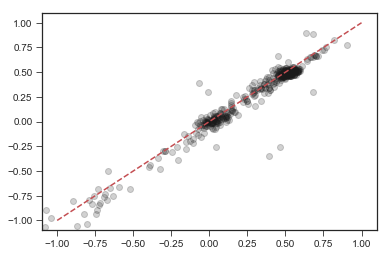

In [225]:
plt.scatter(fitness_data['1BB_0.2MKCl_fitness'],fitness_data['1BB_0.2MNaCl_fitness'],color='k',alpha=0.2)
plt.plot([-1,1],[-1,1],'r--')
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)

In [228]:

train_cols = [col for col in m3_conditions]
for train_col in train_cols:
    for i in range(100):
        fitness_data[f"{train_col.split('_fitness')[0]}_bootstrap{i}_fitness"] = np.random.normal(condition_uncertainties[train_col][0],condition_uncertainties[train_col][1])

In [232]:
fitness_data

,barcode,gene,type,ploidy,class,additional_muts,13.1_T1to2_error,13.1_T1to2_fitness,13.1_T2to3_error,13.1_T2to3_fitness,...,1BB_M3_bootstrap90_fitness,1BB_M3_bootstrap91_fitness,1BB_M3_bootstrap92_fitness,1BB_M3_bootstrap93_fitness,1BB_M3_bootstrap94_fitness,1BB_M3_bootstrap95_fitness,1BB_M3_bootstrap96_fitness,1BB_M3_bootstrap97_fitness,1BB_M3_bootstrap98_fitness,1BB_M3_bootstrap99_fitness
0,53,Diploid,Diploid,Diploid,Diploid,TIP1-upstream_point_variant; YKR012C-upstream_...,1.0,0.580425,1.0,0.030067,...,0.317708,0.350249,0.377389,0.304743,0.368776,0.207697,0.411730,0.509177,0.398151,0.330476
1,151,IRA1,stop_gained,Haploid,PKA,"MIM1,tS-upstream_indel_variant; SEH1-missense_...",1.0,1.745087,1.0,1.564600,...,0.944697,1.124820,1.079243,1.099700,1.044852,1.059038,0.962424,1.106361,1.231689,1.242691
2,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,0.312625,1.0,0.124529,...,0.330520,0.305602,0.573170,0.305420,0.541595,0.365242,0.317787,0.185502,0.557872,0.317071
3,273,IRA1,frameshift_variant,Haploid,PKA,None,1.0,1.366066,1.0,1.129782,...,0.681268,0.721448,1.028326,0.913264,0.825874,0.907859,0.822948,0.712621,0.844383,0.778148
4,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,1.177475,1.0,1.197848,...,0.850544,0.735654,0.839914,0.790701,0.670802,0.740619,0.692180,0.805814,0.831987,0.869335
5,415,IRA1,frameshift_variant,Haploid,PKA,None,1.0,1.462660,1.0,1.488640,...,0.794722,1.097754,1.210721,1.278783,0.881770,1.080496,1.009508,1.105041,1.255935,1.015835
6,499,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,1.373115,1.0,1.244172,...,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157,-1.879157
7,622,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,0.667436,1.0,-0.216333,...,0.347090,0.084400,0.004311,0.089688,0.319876,0.254194,0.384693,0.083734,0.362483,0.740254
8,689,IRA1,frameshift_variant,Haploid,PKA,RPL19A-upstream_point_variant,1.0,1.484334,1.0,1.240727,...,0.596011,1.106400,1.275420,0.622349,1.124551,1.153409,1.127602,0.621481,0.712398,0.840988
9,697,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.0,0.430802,1.0,0.174890,...,0.291573,0.130489,0.123396,0.572318,0.057871,0.320422,0.301563,0.671586,0.314621,0.224208


In [230]:
np.mean(this_fitness[test_mutants,:][:,new_train_locs],axis=1)

array([ 1.19955214e+00,  3.37682515e-01,  8.86060276e-01,  8.96648035e-01,
        4.17247835e-01,  1.05839028e+00,  9.98550479e-01,  3.13896787e-01,
        7.87694648e-01,  1.15017040e-01,  1.48005911e-02,  6.71636917e-01,
        6.79948125e-01,  5.35452035e-01,  4.43137001e-01,  3.69543835e-01,
        2.12706947e-01,  8.07206963e-01,  1.25173960e+00,  2.52510894e-01,
        2.84470378e-01,  8.30537173e-01,  7.24548566e-01,  4.76896854e-01,
        6.52149216e-01,  8.19726287e-01,  7.22109616e-01,  6.66705073e-01,
        2.35942635e-01,  6.96417408e-01,  6.94352930e-02,  3.19799180e-01,
        3.98339247e-01,  1.95432133e-01,  3.54357829e-01,  1.00245234e+00,
        8.73444772e-01,  1.11956121e+00,  8.47523603e-01, -5.69499607e-02,
        4.44834916e-01,  3.92413203e-01,  3.81909602e-01,  6.24302918e-01,
        1.08383623e+00,  8.80934385e-01,  8.56319685e-01,  6.90354691e-02,
        8.76809218e-01,  2.82066448e-01,  9.09936105e-01,  7.69072131e-01,
        3.64022449e-01,  

In [187]:
np.repeat(np.mean(this_fitness[test_mutants,:][:,new_train_locs],axis=1),len(new_test_locs)).reshape(len(test_mutants),len(new_test_locs))

array([[1.19955214, 1.19955214, 1.19955214, ..., 1.19955214, 1.19955214,
        1.19955214],
       [0.33768252, 0.33768252, 0.33768252, ..., 0.33768252, 0.33768252,
        0.33768252],
       [0.88606028, 0.88606028, 0.88606028, ..., 0.88606028, 0.88606028,
        0.88606028],
       ...,
       [0.46285668, 0.46285668, 0.46285668, ..., 0.46285668, 0.46285668,
        0.46285668],
       [0.07440817, 0.07440817, 0.07440817, ..., 0.07440817, 0.07440817,
        0.07440817],
       [0.11994182, 0.11994182, 0.11994182, ..., 0.11994182, 0.11994182,
        0.11994182]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


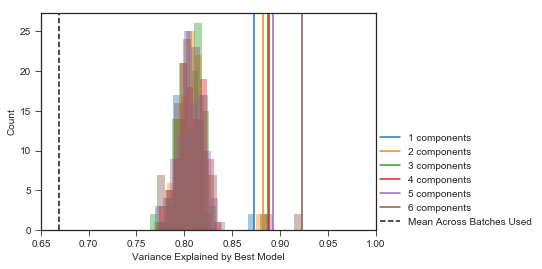

In [273]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

for this_rank in range(6):

    bests = []
    ranks = []

    train_cols = [col + '_fitness' for col in m3_conditions]
    test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]

    all_locs = sorted(list(train_locs)+list(test_locs))

    fitness = this_data[fitness_cols].values
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]

    test_mutants = np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]

    mean_guess = tools.var_explained(this_fitness[test_mutants,:][:,new_test_locs],np.repeat(np.mean(this_fitness[test_mutants,:][:,new_train_locs],axis=1),len(new_test_locs)).reshape(len(test_mutants),len(new_test_locs)))

    for bootstrap in [False]+ list(range(100)):
        if bootstrap != False:
            train_cols = [col.split('_fitness')[0] + f'_bootstrap{bootstrap}_fitness' for col in m3_conditions]
            test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]

        else:

            train_cols = [col + '_fitness' for col in m3_conditions]
            test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]


        fitness_cols = train_cols + test_cols

        fitness = this_data[fitness_cols].values

        n_mutants = fitness.shape[0]
        n_conditions = fitness.shape[1]

        train_conditions = train_cols

        # train_conditions = test_cols
        train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

        test_conditions = test_cols
        # test_conditions = train_cols
        # test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
        test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




        all_locs = sorted(list(train_locs)+list(test_locs))

        this_fitness = fitness[:,all_locs]
        new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
        new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



        train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
        test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


        by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
        by_condition = np.asarray(by_condition).swapaxes(0,1)

    #     bests.append(max(by_rank))
        bests.append(by_rank[this_rank])

        ranks.append(np.where(by_rank==max(by_rank))[0])

    sns.distplot(bests,kde=False)
    plt.axvline(bests[0],color=sns.color_palette()[this_rank],label=f'{this_rank+1} components')
    plt.xlabel('Variance Explained by Best Model')
    plt.ylabel('Count')
    plt.xlim(0.65,1.0)
    
plt.axvline(mean_guess[0],color='k',linestyle='--',label='Mean Across Batches Used')
plt.legend(loc=(1.0,0.0))
# plt.savefig('bootstrap_predictions_compared_to_mean_nosalt_upto6components.pdf',bbox_inches='tight')



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


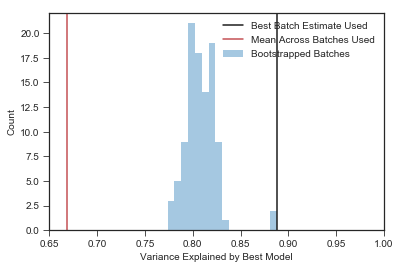

In [267]:


# plt.figure()
# sns.distplot(ranks)
# plt.axvline(ranks[0],color='k')

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


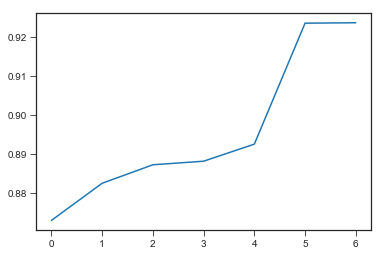

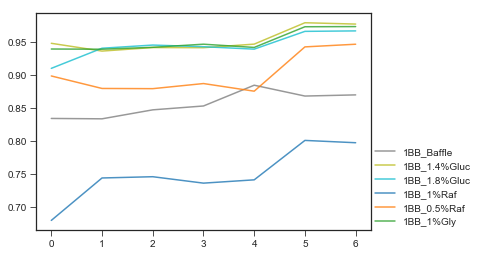

In [313]:
condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


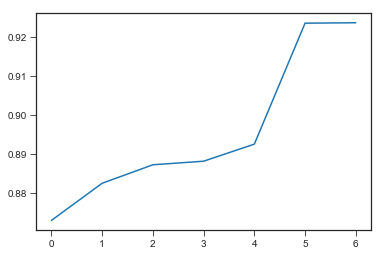

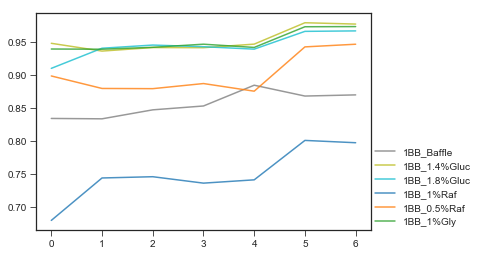

In [282]:

this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

train_cols = [col + '_fitness' for col in m3_conditions]
test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]


fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

# train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
# test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]




# fitness_cols = fitness_data.columns

train_conditions = train_cols

train_conditions = train_cols

# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_0.2MNaCl
1BB_0.2MKCl
1BB_0.5MKCl
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


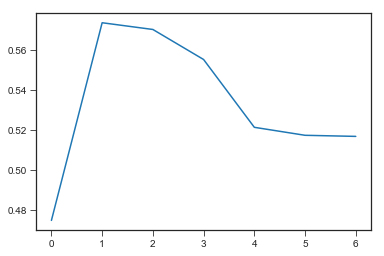

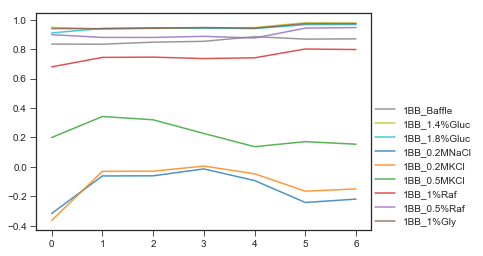

In [64]:

train_conditions = train_cols
# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))

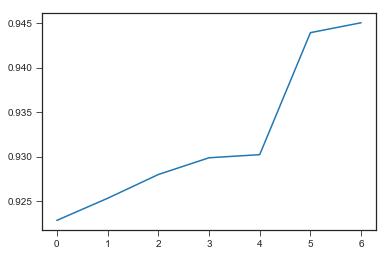

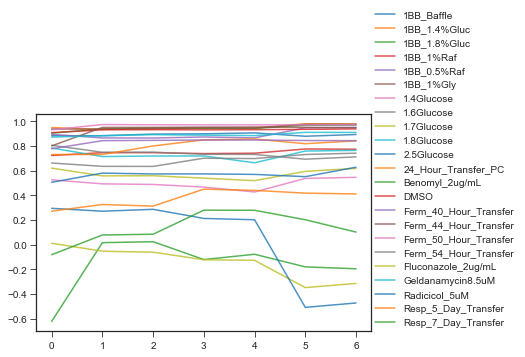

In [328]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

train_cols = [col + '_fitness' for col in m3_conditions]
test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions]

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

train_conditions = train_cols
# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    

#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
#     index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
#     index = np.where(test_conditions==condition)[0]
    
    index =  k % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend(loc=(1.0,0.0))

In [325]:
condition

'1BB_Baffle_fitness'

In [326]:
test_conditions

['1BB_Baffle_fitness',
 '1BB_1.4%Gluc_fitness',
 '1BB_1.8%Gluc_fitness',
 '1BB_1%Raf_fitness',
 '1BB_0.5%Raf_fitness',
 '1BB_1%Gly_fitness',
 '1.4Glucose_fitness',
 '1.6Glucose_fitness',
 '1.7Glucose_fitness',
 '1.8Glucose_fitness',
 '2.5Glucose_fitness',
 '24_Hour_Transfer_PC_fitness',
 'Benomyl_2ug/mL_fitness',
 'DMSO_fitness',
 'Ferm_40_Hour_Transfer_fitness',
 'Ferm_44_Hour_Transfer_fitness',
 'Ferm_50_Hour_Transfer_fitness',
 'Ferm_54_Hour_Transfer_fitness',
 'Fluconazole_2ug/mL_fitness',
 'Geldanamycin8.5uM_fitness',
 'Radicicol_5uM_fitness',
 'Resp_5_Day_Transfer_fitness',
 'Resp_7_Day_Transfer_fitness']

In [324]:
np.where(test_conditions==condition)

(array([], dtype=int64),)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x11df7b2b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x12f6fd400> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x116c83898> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning:

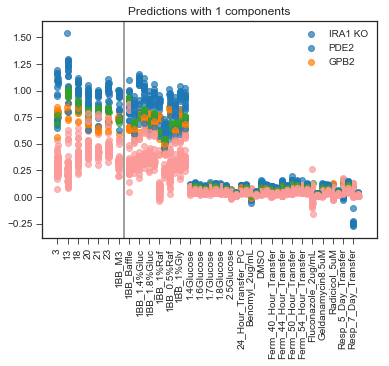

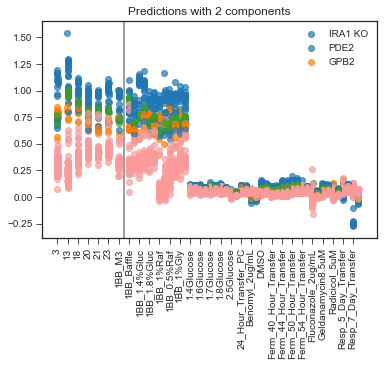

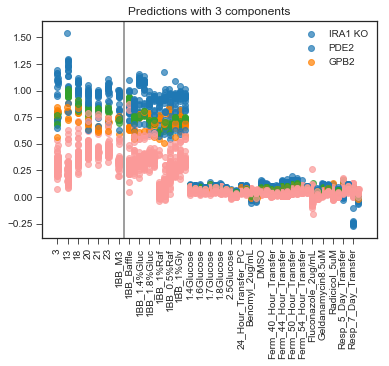

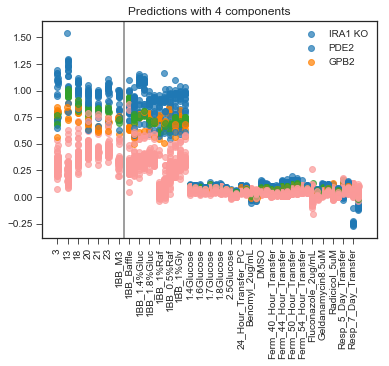

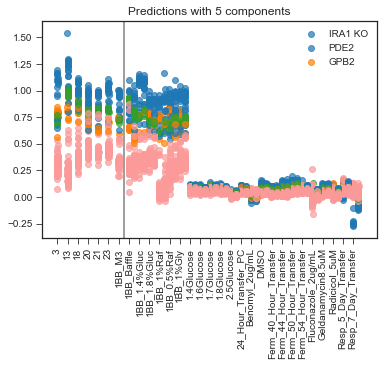

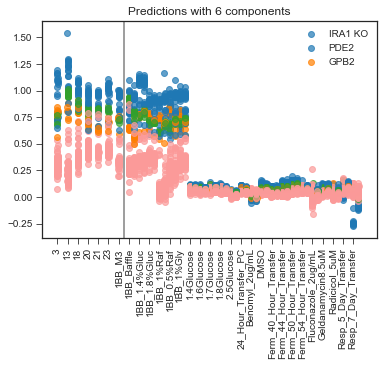

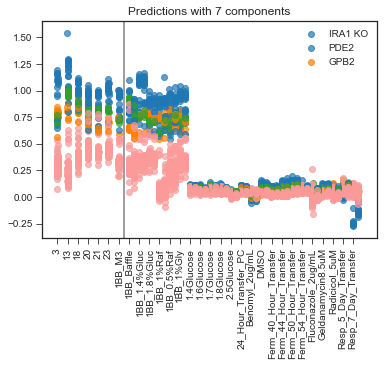

In [329]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

for rank in range(7):
    plt.figure()
    plt.title(f'Predictions with {rank+1} components')
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
#     sns.boxplot(data=guesses[rank][this_gene_locs,:])
    
    plt.axvline(x=len(train_conditions)+0.5,color='gray')
    plt.legend(['_nolegend_','IRA1 KO','PDE2','_nolegend_','GPB2'])
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)
    
    
#     plt.savefig('predictions_by_gene_{rank+1}components.pdf',bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


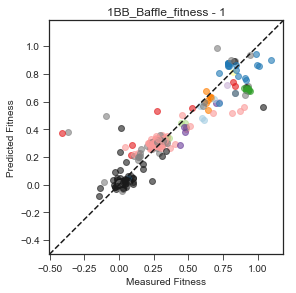

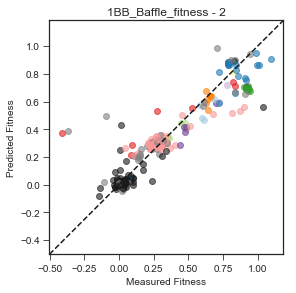

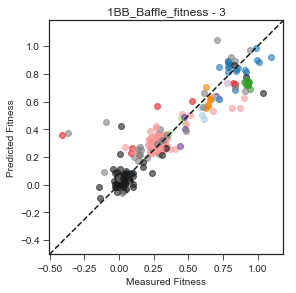

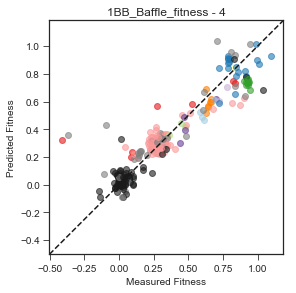

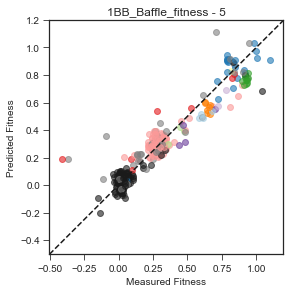

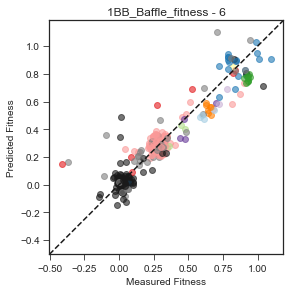

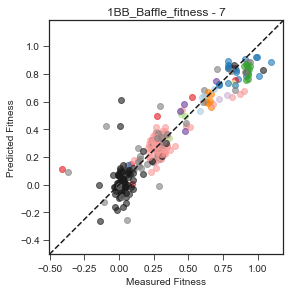

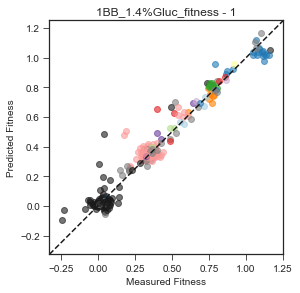

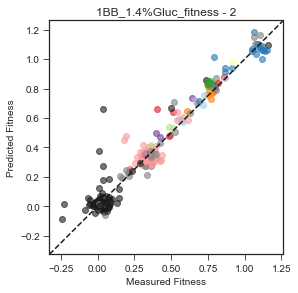

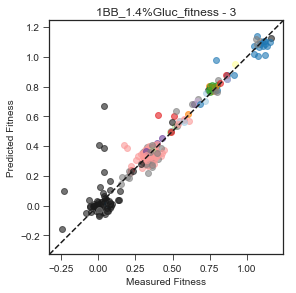

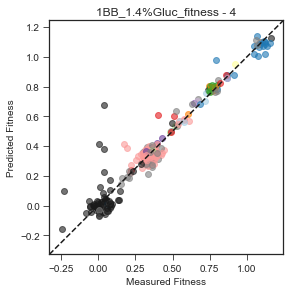

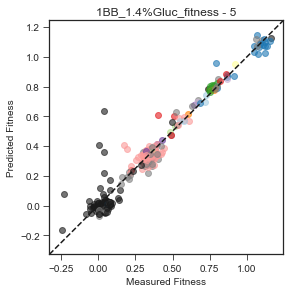

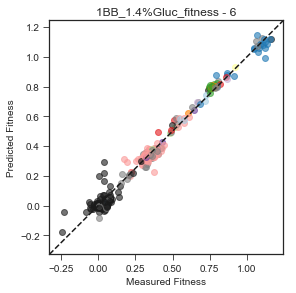

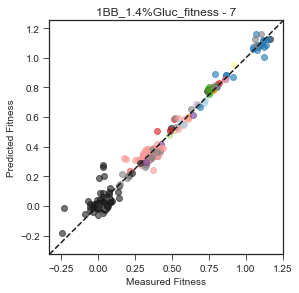

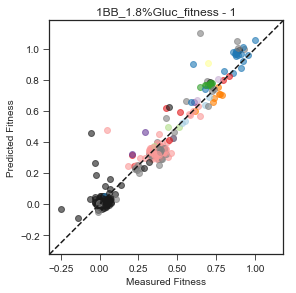

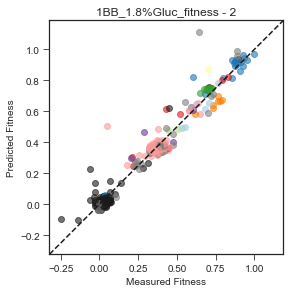

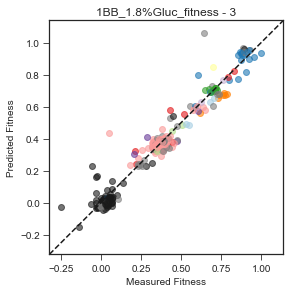

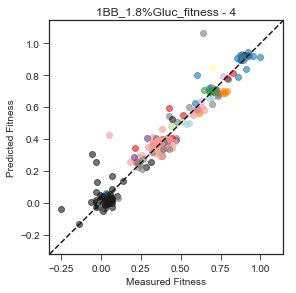

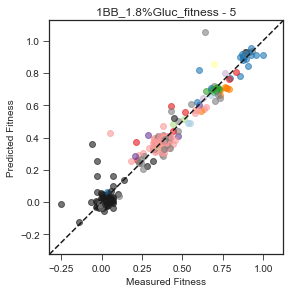

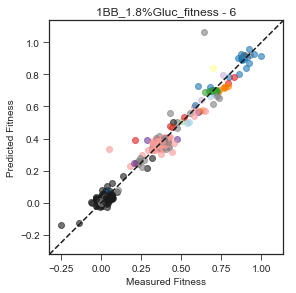

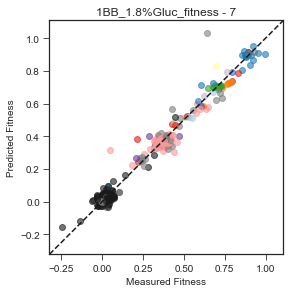

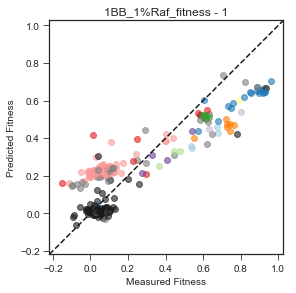

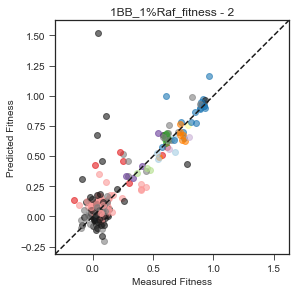

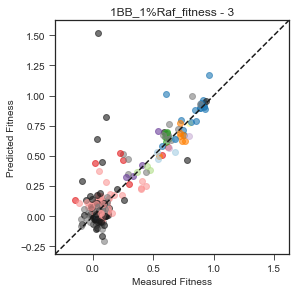

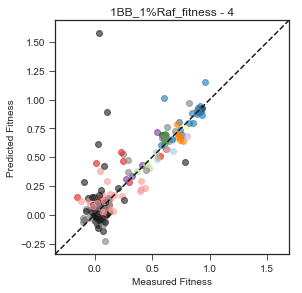

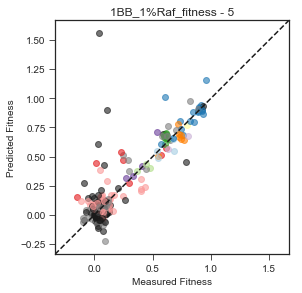

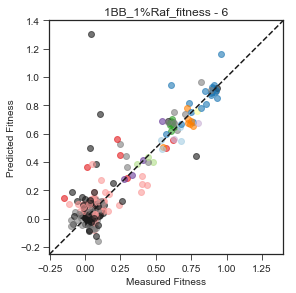

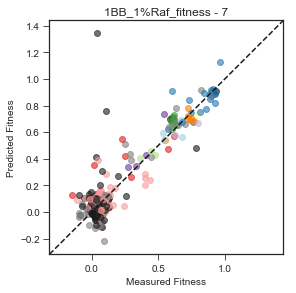

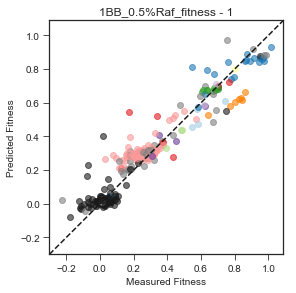

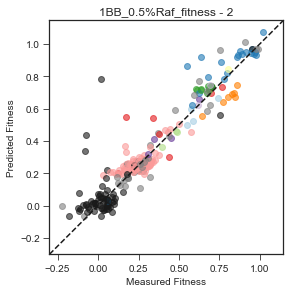

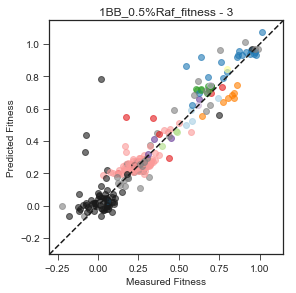

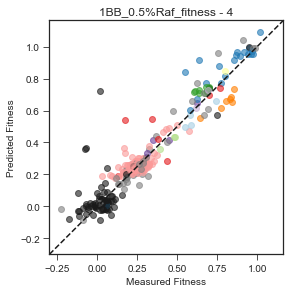

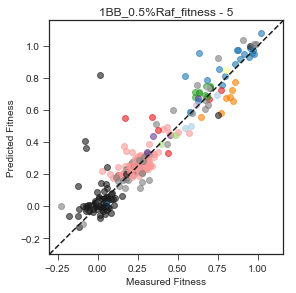

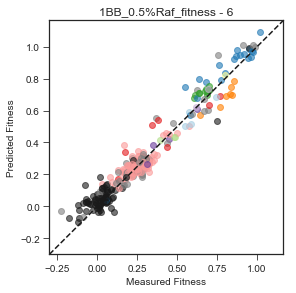

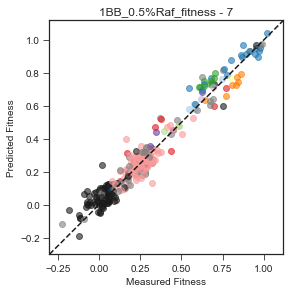

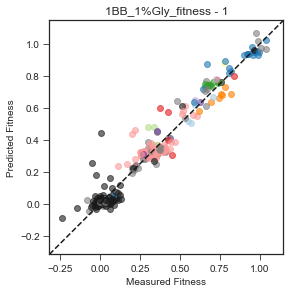

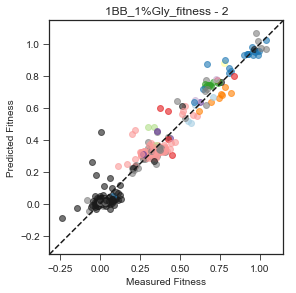

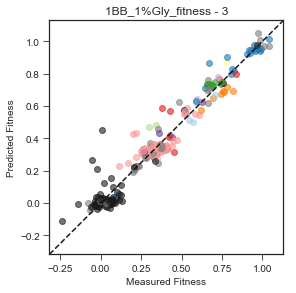

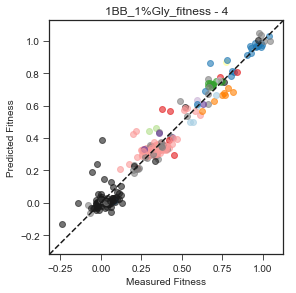

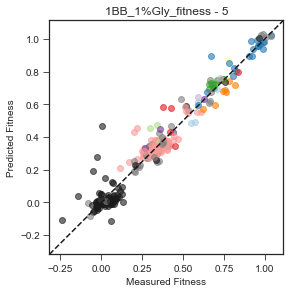

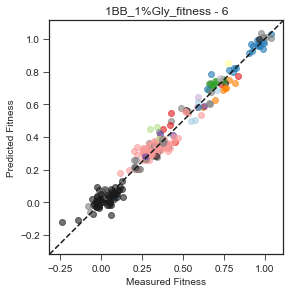

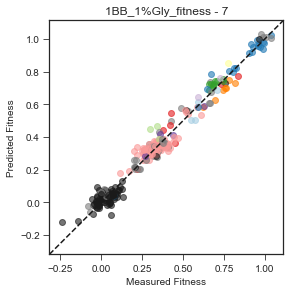

In [283]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


# this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
# this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

this_gene_data = test_mutant_data

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

for i,col in enumerate(test_conditions):
    for rank in range(len(guesses)):
        plt.figure()
        plt.title(f'{col} - {rank+1}')
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter(this_gene_data[col].values[bc],guesses[rank][this_gene_locs[bc],i],color=mutant_colorset[this_gene_data['gene'].values[bc]],alpha=0.6)
        
        xmin,xmax = plt.xlim()
        ymin,ymax = plt.ylim()
        plt.xlim(min(xmin,ymin),max(xmax,ymax))
        plt.ylim(min(xmin,ymin),max(xmax,ymax))
        plt.tight_layout()
        plt.plot([min(xmin,ymin),max(xmax,ymax)],[min(xmin,ymin),max(xmax,ymax)],'k--')
        plt.gca().set_aspect('equal')
        plt.xlabel('Measured Fitness')
        plt.ylabel('Predicted Fitness')
        plt.savefig(f'predictions_by_gene_sidebyside_{col}_{rank+1}components.pdf',bbox_inches='tight')

In [74]:
this_data[this_data['barcode']==this_data['barcode'].values[55]][train_conditions+test_conditions].values

array([[-0.0797669 ,  0.01417236, -0.05644245, -0.05836564, -0.04170214,
        -0.02043665,  0.00849465, -0.01985987,  0.03937098,  0.01264094,
         0.06193405,  0.00542039, -0.01789558,  0.03744408, -0.05614371,
        -0.02542603]])

In [85]:
this_data[this_data['class'].isin(['ExpNeutral'])]

,barcode,gene,type,ploidy,class,additional_muts,13.1_T1to2_error,13.1_T1to2_fitness,13.1_T2to3_error,13.1_T2to3_fitness,...,D.DE1.PCRb.1-D.DE1.PCRb.2_error,D.DE1.PCRb.1-D.DE1.PCRb.2_fitness,D.DE1.PCRb.2-D.DE1.PCRa.3_error,D.DE1.PCRb.2-D.DE1.PCRa.3_fitness,D.DE1.PCRb.2-D.DE1.PCRb.3_error,D.DE1.PCRb.2-D.DE1.PCRb.3_fitness,D.DE1.PCRb.3-D.DE1.PCRa.4_error,D.DE1.PCRb.3-D.DE1.PCRa.4_fitness,D.DE1.PCRb.3-D.DE1.PCRb.4_error,D.DE1.PCRb.3-D.DE1.PCRb.4_fitness
292,72939,NotSequenced,NotSequenced,NotSequenced,ExpNeutral,NotSequenced,1.0,0.058130,1.0,0.044166,...,1.0,-0.106077,1.0,0.104692,1.0,0.231084,1.0,-0.064463,1.0,-0.038010
357,120600,other,other,other,ExpNeutral,nan-upstream_indel_variant,1.0,-0.022603,1.0,-0.036836,...,1.0,0.085671,1.0,-0.262471,1.0,-0.011153,1.0,-0.074272,1.0,0.052239
474,298344,other,other,other,ExpNeutral,FYV10-upstream_indel_variant; YKL177W-upstream...,1.0,-0.190787,1.0,0.170166,...,1.0,-0.140856,1.0,0.389522,1.0,0.212395,1.0,0.038669,1.0,-0.012900


In [88]:
this_data[this_data['gene']=='other']

,barcode,gene,type,ploidy,class,additional_muts,13.1_T1to2_error,13.1_T1to2_fitness,13.1_T2to3_error,13.1_T2to3_fitness,...,D.DE1.PCRb.1-D.DE1.PCRb.2_error,D.DE1.PCRb.1-D.DE1.PCRb.2_fitness,D.DE1.PCRb.2-D.DE1.PCRa.3_error,D.DE1.PCRb.2-D.DE1.PCRa.3_fitness,D.DE1.PCRb.2-D.DE1.PCRb.3_error,D.DE1.PCRb.2-D.DE1.PCRb.3_fitness,D.DE1.PCRb.3-D.DE1.PCRa.4_error,D.DE1.PCRb.3-D.DE1.PCRa.4_fitness,D.DE1.PCRb.3-D.DE1.PCRb.4_error,D.DE1.PCRb.3-D.DE1.PCRb.4_fitness
16,1641,other,other,other,other,nan-nan,1.0,0.183488,1.0,0.055235,...,1.0,-0.174079,1.0,0.107723,1.0,0.094027,1.0,0.094105,1.0,0.199129
17,1683,other,other,other,other,SDH3-upstream_point_variant; MFM1-missense_var...,1.0,0.092495,1.0,-0.178251,...,1.0,-0.023457,1.0,0.090384,1.0,-0.103985,1.0,0.236495,1.0,0.245908
53,7291,other,other,other,other,"IMP4-missense_variant; YER156C,COG3-upstream_i...",1.0,-0.122278,1.0,0.003392,...,1.0,-0.036893,1.0,0.058277,1.0,0.066181,1.0,0.085515,1.0,-0.120820
56,7538,other,other,other,other,SEC31-synonymous_variant; ERG1-missense_varian...,1.0,0.892983,1.0,0.598109,...,1.0,-0.038893,1.0,-0.197483,1.0,0.066257,1.0,-0.039292,1.0,0.147415
62,7953,other,other,other,other,nan-nan,1.0,1.212985,1.0,1.076551,...,1.0,0.806385,1.0,0.891071,1.0,0.653368,1.0,0.732599,1.0,0.802753
68,8825,other,other,other,other,ATG32-upstream_indel_variant,1.0,-0.003088,1.0,-0.126550,...,1.0,-0.193931,1.0,-0.214006,1.0,0.232056,1.0,0.032620,1.0,-0.076126
77,10307,other,other,other,other,nan-nan,1.0,0.151889,1.0,0.080794,...,1.0,-0.160825,1.0,0.162019,1.0,-0.236642,1.0,0.114391,1.0,0.064709
97,13183,other,other,other,other,nan-nan,1.0,1.418840,1.0,1.330550,...,1.0,0.102428,1.0,-0.224542,1.0,-0.175302,1.0,0.017579,1.0,0.090621
113,17499,other,other,other,other,LCP5-upstream_indel_variant; PTC3-synonymous_v...,1.0,-0.169470,1.0,0.444566,...,1.0,-0.099572,1.0,-0.256100,1.0,0.047418,1.0,0.251171,1.0,0.008007
117,18152,other,other,other,other,KTI12-missense_variant,1.0,1.436099,1.0,1.338601,...,1.0,0.930502,1.0,1.074372,1.0,1.115791,1.0,0.934102,1.0,0.920605


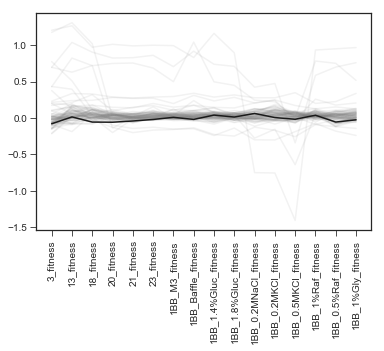

In [91]:
# np.where(guesses[1][:,6] > 1.5)
for bc in this_data[this_data['gene']=='other']['barcode'].values:
    plt.plot(this_data[this_data['barcode']==bc][train_conditions+test_conditions].values[0],color='gray',alpha=0.1)




# for bc in neutrals:
#     if bc in this_data['barcode'].values:
#         plt.plot(this_data[this_data['barcode']==bc][train_conditions+test_conditions].values[0],color='gray')

plt.plot(this_data[this_data['barcode']==this_data['barcode'].values[55]][train_conditions+test_conditions].values[0],color='k')
plt.xticks(range(len(train_conditions+test_conditions)),train_conditions+test_conditions,rotation=90)
plt.savefig('weirdly_predicted_neutral_Raffionse.pdf',bbox_inches='tight')

In [53]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1']
# this
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[col].values)) ]

for rank in range(7):
    plt.figure()
    plt.title(f'Predictions with {rank+1} components')
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
#     for i,col in enumerate(test_conditions):
#         for bc in range(len(this_gene_data[col].values)):
#             plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    sns.boxplot(data=guesses[rank][this_gene_locs,:])
    
    plt.axvline(x=len(train_conditions)+0.5,color='gray')
    plt.legend(['_nolegend_','IRA1 KO','PDE2','_nolegend_','GPB2'])
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)
    
    
#     plt.savefig('predictions_by_gene_{rank+1}components.pdf',bbox_inches='tight')

NameError: name 'col' is not defined

1BB_Baffle
1BB_1.4%Gluc
1BB_1.8%Gluc
1BB_0.2MNaCl
1BB_0.2MKCl
1BB_0.5MKCl
1BB_1%Raf
1BB_0.5%Raf
1BB_1%Gly


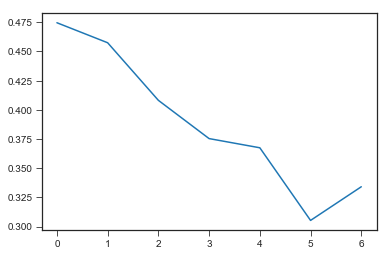

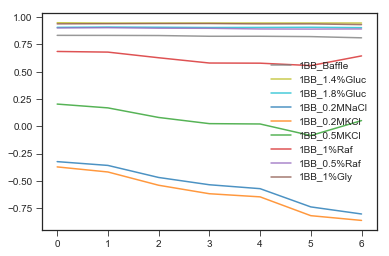

In [96]:

train_conditions = train_cols
# train_conditions = test_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
# test_conditions = train_cols
# test_conditions = [rep for rep in  test_conditions if rep.split('_')[0] in all_reps]
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]




all_locs = sorted(list(train_locs)+list(test_locs))

this_fitness = fitness[:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]



train = [new_train_locs,np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
test = [new_test_locs,np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]


by_rank, by_condition, by_mutant, mean_fits, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True,permuted_mutants=True)
by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)
plt.figure()
start = 0
already_plotted = []



for k,condition in enumerate(test_conditions):
    condition = condition.split('_fitness')[0]
    print(condition)
#     condition_name = [name for name, reps in conditions.items() for rep in reps if rep == condition][0]
    condition_name = condition
    index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
    
    index =  index % len(condition_colors)
    if condition_name not in already_plotted:
        plt.plot(by_condition[k],label=condition_name,color=condition_colors[index],alpha=0.8)
        already_plotted.append(condition_name)
    else:
        plt.plot(by_condition[k],color=condition_colors[index],alpha=0.8)
plt.legend()

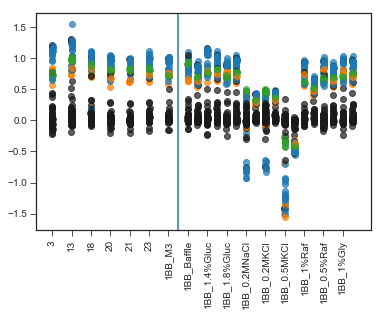

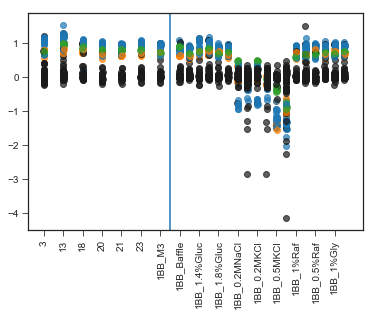

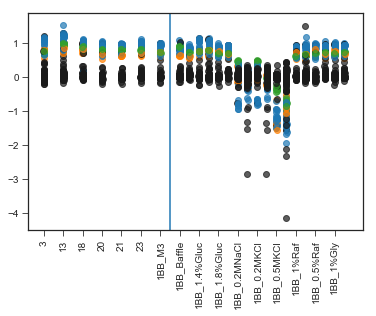

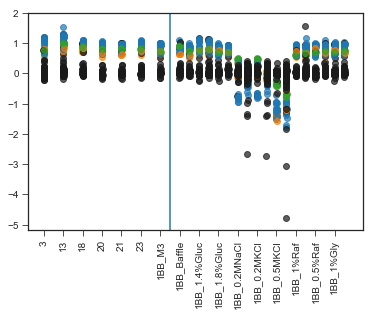

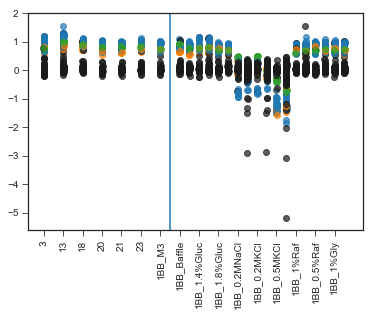

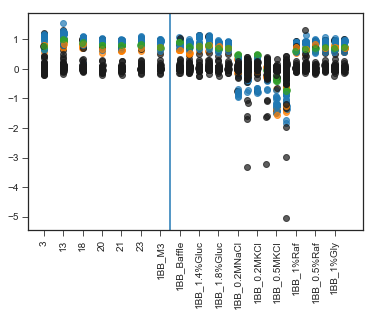

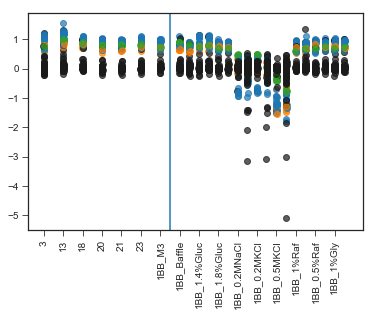

In [215]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


this_gene = ['GPB2','PDE2','IRA1','other']
this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[col].values)) ]

for rank in range(7):
    plt.figure()
    for i,col in enumerate(train_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
    
    plt.gca().set_prop_cycle(None)
    for i,col in enumerate(test_conditions):
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter([len(train_conditions)+i + 1 + 0.5 + jitters[bc]],guesses[rank][this_gene_locs[bc],i],alpha=0.7,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 
#     plt.boxplot(guesses[rank][this_gene_locs,:])
    plt.axvline(x=len(train_conditions)+0.5)
    plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (train_conditions + test_conditions)],rotation=90)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


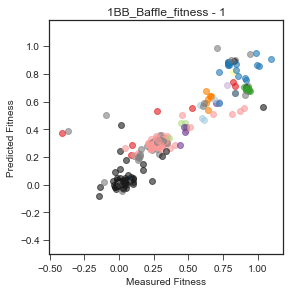

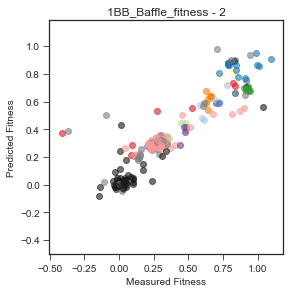

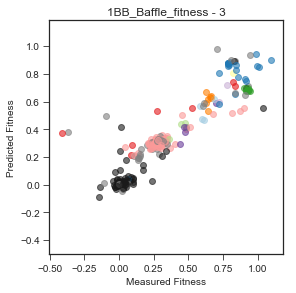

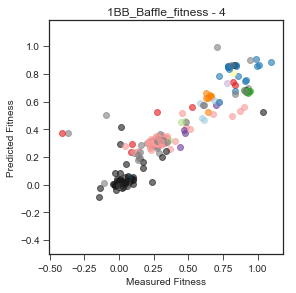

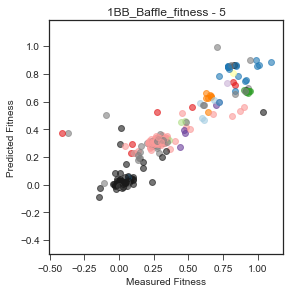

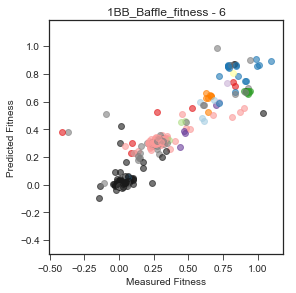

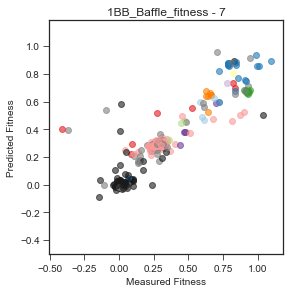

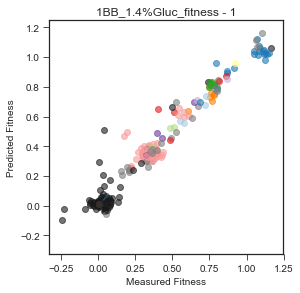

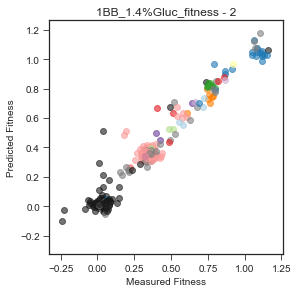

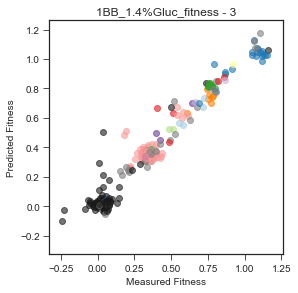

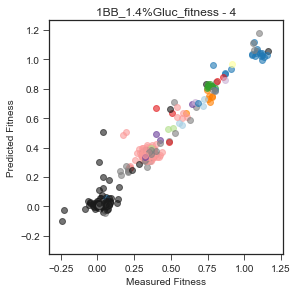

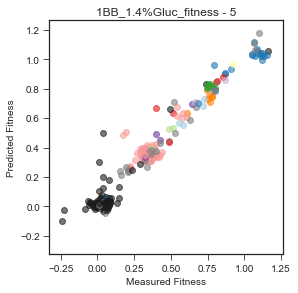

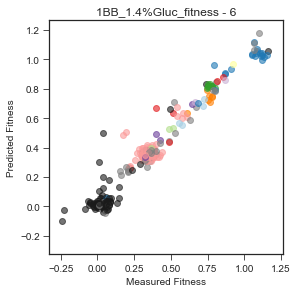

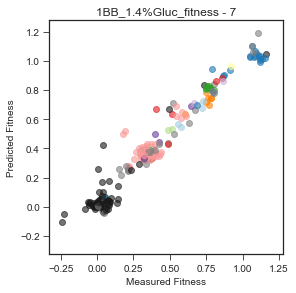

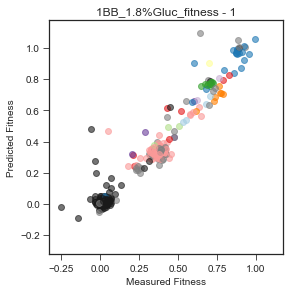

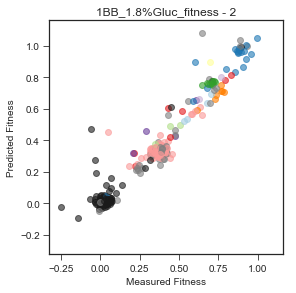

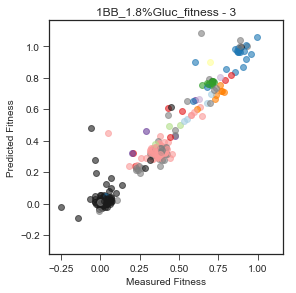

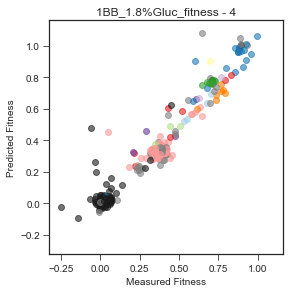

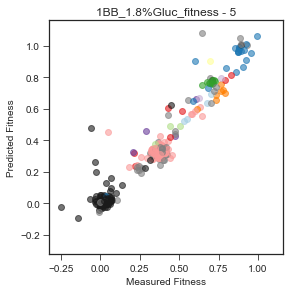

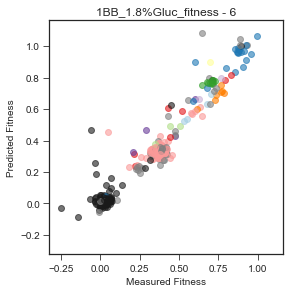

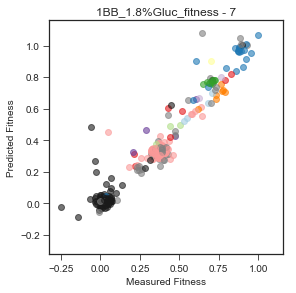

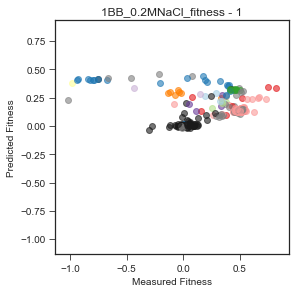

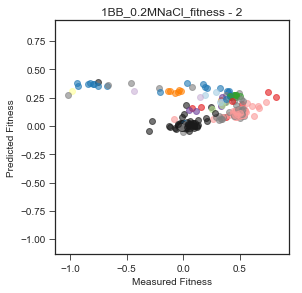

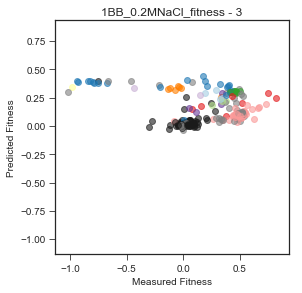

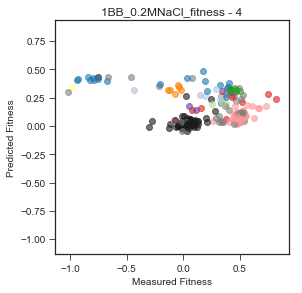

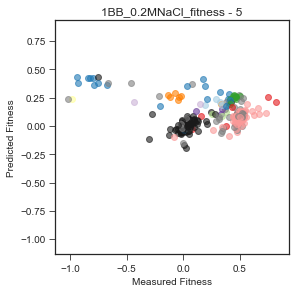

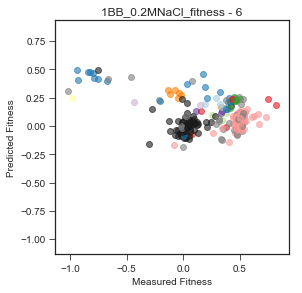

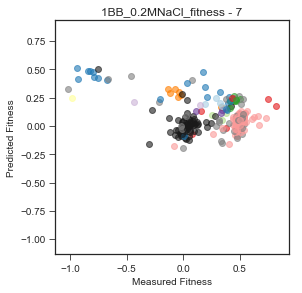

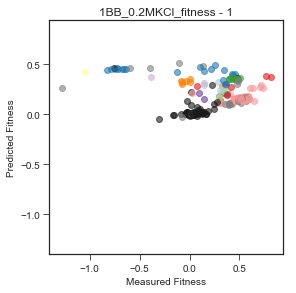

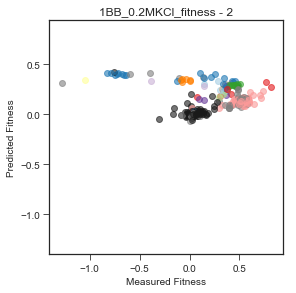

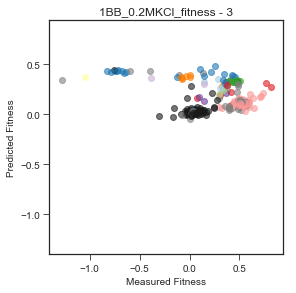

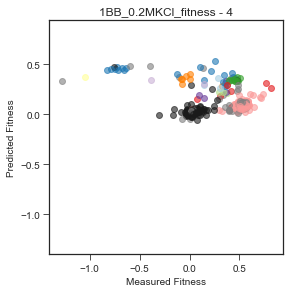

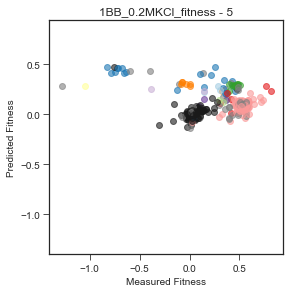

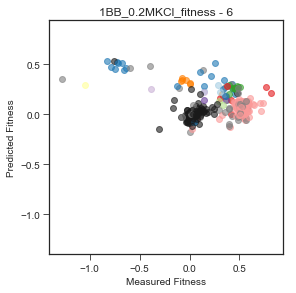

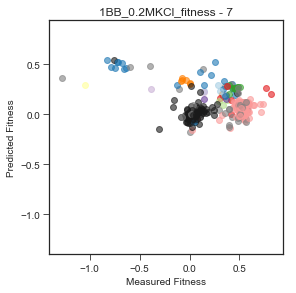

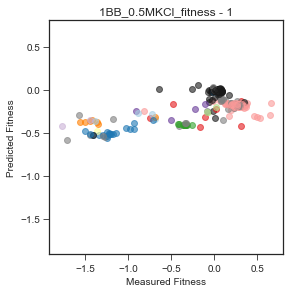

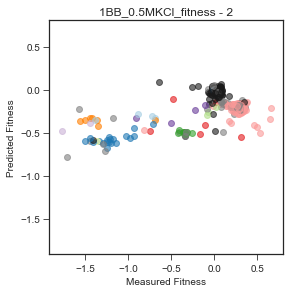

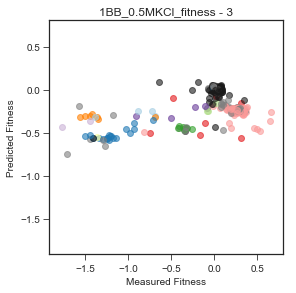

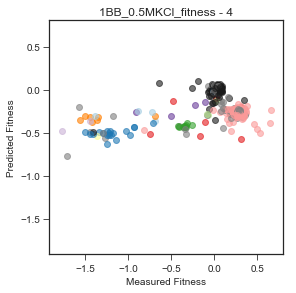

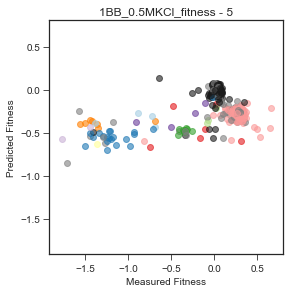

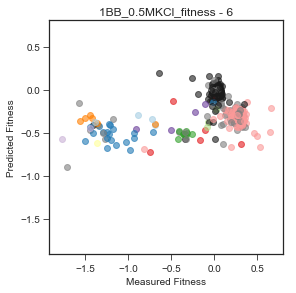

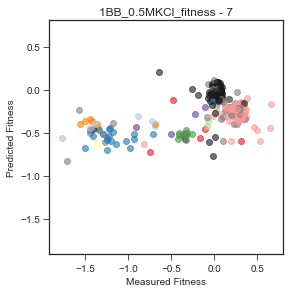

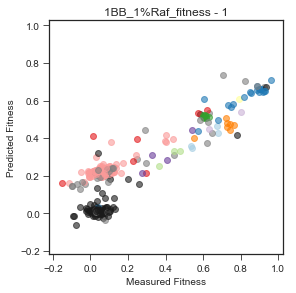

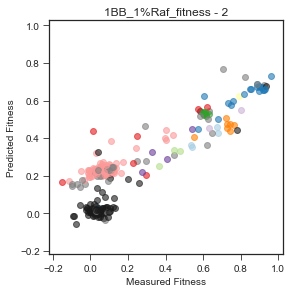

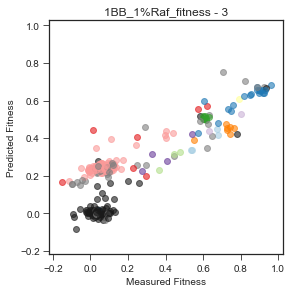

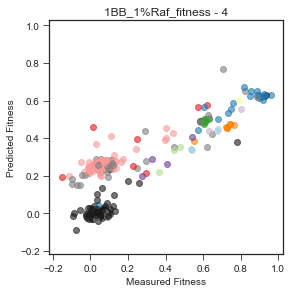

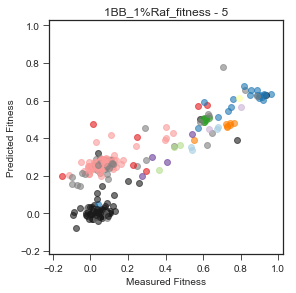

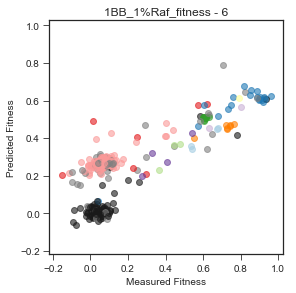

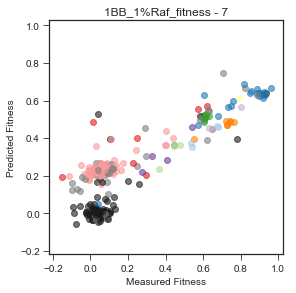

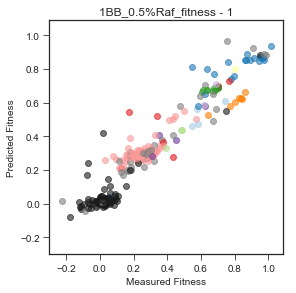

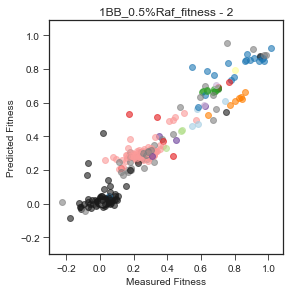

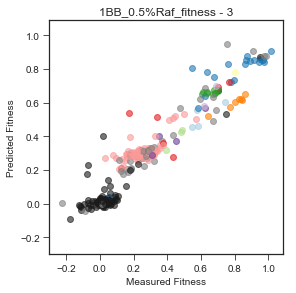

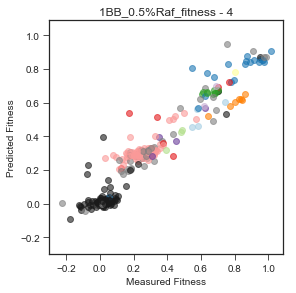

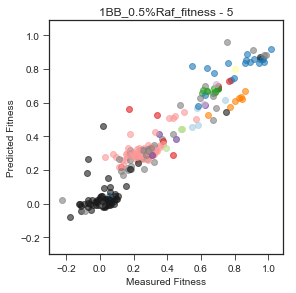

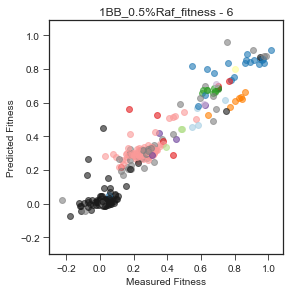

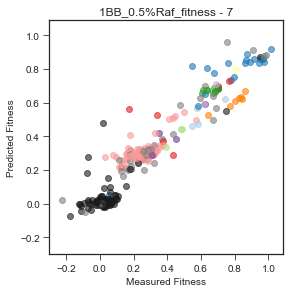

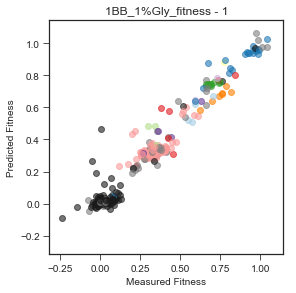

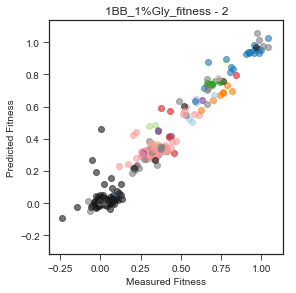

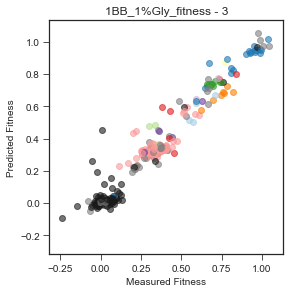

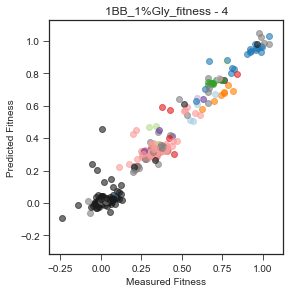

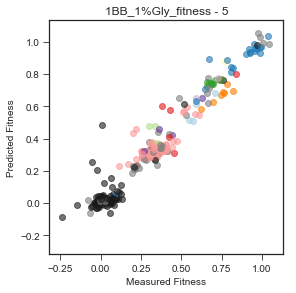

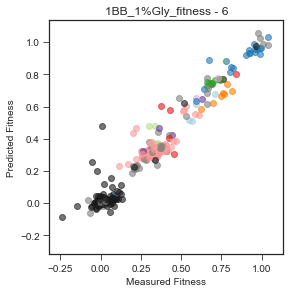

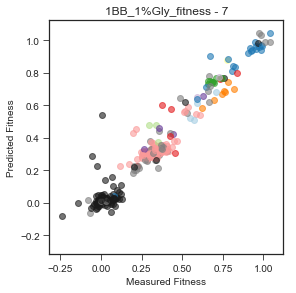

In [97]:
test_mutant_data = this_data[~this_data['barcode'].isin(training_bcs)]


# this_gene = ['GPB2','PDE2','IRA1','Diploid']
# this
# this_gene_data = test_mutant_data[test_mutant_data['gene'].isin(this_gene)]

this_gene_data = test_mutant_data

# type_list = ['nonsense_variant','frameshift_variant']
# type_list = ['missense_variant']
# this_gene_data = this_gene_data[this_gene_data['type'].isin(type_list)]


this_gene_locs = np.where(np.isin(test_mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

for i,col in enumerate(test_conditions):
    for rank in range(len(guesses)):
        plt.figure()
        plt.title(f'{col} - {rank+1}')
        for bc in range(len(this_gene_data[col].values)):
            plt.scatter(this_gene_data[col].values[bc],guesses[rank][this_gene_locs[bc],i],color=mutant_colorset[this_gene_data['gene'].values[bc]],alpha=0.6)
        
        xmin,xmax = plt.xlim()
        ymin,ymax = plt.ylim()
        plt.xlim(min(xmin,ymin),max(xmax,ymax))
        plt.ylim(min(xmin,ymin),max(xmax,ymax))
        plt.tight_layout()
        plt.gca().set_aspect('equal')
        plt.xlabel('Measured Fitness')
        plt.ylabel('Predicted Fitness')
        plt.savefig(f'predictions_by_gene_sidebyside_permuted_{col}_{rank+1}components.pdf',bbox_inches='tight')

In [12]:
p = Pool(10)
entries = [[this_fitness,train,test,n_components] for n_components in range(1,25)]
# (,by_condition=True,by_mutant=False)
output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

KeyboardInterrupt: 

Process ForkPoolWorker-39:
Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-32:
Process ForkPoolWorker-37:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-31:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framewo

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1724, in pinv
    u, s, vt = svd(a, full_matrices=False)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1444, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/linalg

In [36]:
%%time
if __name__ ==  '__main__': 
    p = Pool(10)
    entries = [[this_fitness,train,test,n_components,False,False] for n_components in range(1,25)]
    # (,by_condition=True,by_mutant=False)
    output = p.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)

CPU times: user 1min 36s, sys: 1min 20s, total: 2min 56s
Wall time: 1h 13min 51s


In [50]:
output[0][0]

[0.7775464290186149,
 -1.7462627649199987,
 -1.7322641952199276,
 -1.8075848574009248,
 -1.8071511589631837,
 -1.8039558786969931,
 -1.8103381478808624,
 -1.8074569334136434,
 -1.7884100100802862,
 -1.794749121032754,
 -1.8362844687658728,
 -1.8034855936533494,
 -1.893842230766019,
 -1.8112373698713573,
 -1.816097188453781,
 -1.8124588165782156,
 -1.8164305059075976,
 -1.8163543693231108,
 -1.8102422591361833,
 -1.796341314905836,
 -1.8078083617314307,
 -1.804494066515543,
 -1.8175237432201117,
 -1.794151939431321]

In [54]:
sort_list = []
for o in output:
    sort_list.append(sorted([(o1,o2) for o1,o2 in zip(o[0],o[4])],reverse=True))
    

In [55]:
sorted_rank_combos = sort_list

RuntimeError: Failed to open TrueType font

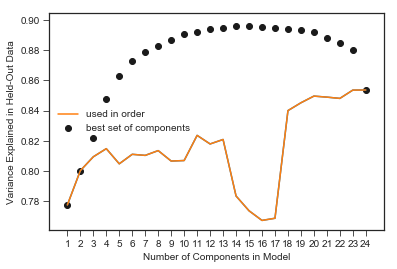

In [57]:
by_rank, by_condition, by_mutant, mean_fits = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=False)
# by_condition = np.asarray(by_condition).swapaxes(0,1)

condition_colors = sns.color_palette()
plt.plot(by_rank)

for rank in range(len(sorted_rank_combos)):
    plt.scatter(rank,sorted_rank_combos[rank][0][0],color='k',label='best set of components' if rank ==0 else '_nolegend_')
plt.plot(by_rank,label='used in order')
# plt.savefig('predictions_best_per_rank.pdf',bbox_inches='tight')
plt.xticks(range(len(by_rank)),range(1,len(by_rank)+1))
plt.xlabel('Number of Components in Model')
plt.ylabel('Variance Explained in Held-Out Data')
plt.legend()
plt.savefig('best_set_vs_in_order_all.pdf',bbox_inches='tight')

In [31]:
%%time
o = []
for n_components in range(1,5):
    by_rank, by_condition, by_mutant, mean_fits, component_sets = tools.SVD_predictions_train_test_mixnmatch(this_fitness,train,test,n_components,by_condition=True,by_mutant=False)
    o.append(sorted([(rank,combo) for rank,combo in zip(by_rank,component_sets)],reverse=True))



CPU times: user 15.1 s, sys: 470 ms, total: 15.6 s
Wall time: 34.6 s


In [63]:
sorted_rank_combos[6]

[(0.8785819075879436, [0, 1, 2, 9, 10, 12, 17]),
 (0.8770446318593077, [0, 1, 2, 7, 10, 12, 17]),
 (0.8763761257533184, [0, 1, 2, 3, 10, 12, 17]),
 (0.876272100070757, [0, 1, 2, 5, 10, 12, 17]),
 (0.8752940410415991, [0, 1, 2, 10, 12, 17, 19]),
 (0.8739377955644658, [0, 1, 2, 10, 12, 16, 17]),
 (0.8737460397343314, [0, 1, 2, 6, 10, 12, 17]),
 (0.873565355369854, [0, 1, 2, 10, 11, 12, 17]),
 (0.87297186151656, [0, 1, 2, 3, 8, 10, 17]),
 (0.8727238941920381, [0, 1, 2, 10, 12, 17, 23]),
 (0.8723689696864775, [0, 1, 2, 10, 12, 17, 21]),
 (0.8722390689577192, [0, 1, 2, 10, 12, 17, 20]),
 (0.8714454687763196, [0, 1, 2, 7, 8, 10, 17]),
 (0.8713969764924173, [0, 1, 2, 8, 10, 17, 19]),
 (0.8708718512808002, [0, 1, 2, 10, 12, 17, 18]),
 (0.8708306655632606, [0, 1, 2, 5, 8, 10, 17]),
 (0.8707817426646477, [0, 1, 2, 8, 10, 14, 17]),
 (0.8707719842860515, [0, 1, 2, 3, 5, 10, 17]),
 (0.8704256336135026, [0, 1, 2, 8, 10, 16, 17]),
 (0.870276423848967, [0, 1, 2, 3, 7, 10, 17]),
 (0.8699833141457991, [